# Домашнее задание. Градиентный спуск

## Краткое напоминание
Рассматривается задача минимизации $f(x) \to \min\limits_{x \in \mathbb{R}^n}$
$$
x_{k+1} = x_k - \eta_k \nabla f(x_k)
$$

## Задача 1. Убираем шум с фотографии (denoising).
Будем рассматривать изображение, как скалярную функцию от двух переменных (координаты $x$ и $y$):
$$
f(x,y): \mathbb{R}^d \to \mathbb{R} \;\;\;\;\;\; (d = n \times n)
$$

Мы нарисуем енотика, который есть у всех. Вы можете загрузить Ваше любимое изображение с помощью функции [`imread`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.misc.imread.html). Люди, выполнившие задание полностью смогут принять участие в конкурсе самых мемных картинок по мнению преподавателя.

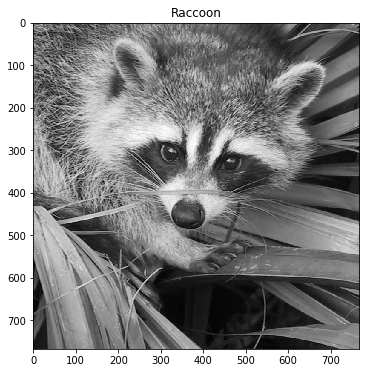

In [2]:
# Libraries
import sys
%matplotlib inline
from scipy import misc
import matplotlib.pyplot as plt
import numpy as np

# Uploading and normalizing the image of raccoon
enot = (misc.face(gray = True)/255)[:, -768:]

# Plotting
#plt.figure(figsize=(8,8))
plt.rcParams["figure.figsize"] = [6,6]
plt.imshow(enot, cmap='gray')
# plt.axis('off')
plt.title('Raccoon')

plt.show()

Пошумим? Добавим двухмерный гауссов шум с нулевым средним и задаваемой дисперсией
$$
y = enot(x,y) + \mathcal{N}(0, \sigma)
$$

Прошу заметить, что чтобы был лучше заметен результат взял $\sigma = 0.3$ вместо $\sigma = 0.1$ по-умолчанию 

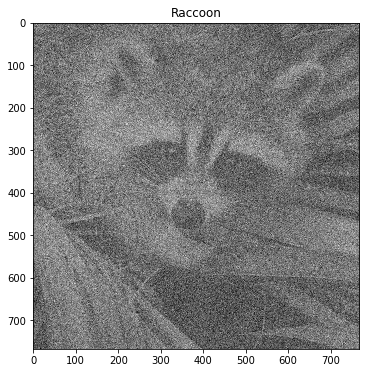

In [3]:
# Enot's size
n = enot.shape[1]

# Add some noise
sigma = 0.3
y = (enot + sigma*np.random.randn(n,n))

# Plotting
plt.rcParams["figure.figsize"] = [6,6]
plt.imshow(y, cmap='gray')
# plt.axis('off')
plt.title('Raccoon')
plt.show()

Задача заключается в том, как, имея только шумное изображение $y$, получить максимально близкое к исходному (как минимум, менее шумное). Наша задача будет формулироваться следующим образом: 

$$
\min_{x \in R^d} f(x) = \frac{1}{2} \|y-x\|^2 + \lambda J(x),
$$

где $J(x)$ - некоторая функция, которая характеризует шумность (зернистость) картинки. То есть, решая задачу оптимизации мы должны получить с одной стороны изображение, близкое к $y$, с другой стороны, как можно менее шумное. Остается один важный вопрос - *что из себя представляет функция $J(x)$?*

### Подход бедных студентов
В каждой точке изображения можно посчитать производную по двум координтам. Таким образом, если изображение это функция $enot(x, y): \mathbb{R}^d \to \mathbb{R}$, то её градиент - это функция $\nabla enot(x,y): \mathbb{R}^d \to \mathbb{R}^2$, представляющая в каждой точке вектор из двух компонент $\left( \dfrac{\partial \;enot}{\partial x}, \dfrac{\partial \;enot}{\partial y} \right)$. Полный набор по все точкам - тензор размера $n \times n \times 2$

Величина градиента в каждой точке может быть оценена как

$$
g(x_i, y_i) = \sqrt{\left(\dfrac{\partial \;enot}{\partial x} (x_i, y_i)\right)^2 + \left(\dfrac{\partial \;enot}{\partial y} (x_i, y_i)\right)^2}
$$

Тогда будем строить $J(x)$ следующим образом:
$$
J(x) = \sum\limits_{x_i,y_i} \left[g(x_i, y_i)^2 \right]
$$

Тогда он будет характеризовать некоторую кумулятивную величину изменения значения пикселя по всему изображению. [Метод конечных разностей](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BA%D0%BE%D0%BD%D0%B5%D1%87%D0%BD%D1%8B%D1%85_%D1%80%D0%B0%D0%B7%D0%BD%D0%BE%D1%81%D1%82%D0%B5%D0%B9) поможет оценить величину частной производной. Для решения проблемы с граничными значениями можно, например, считать, что изображение циклично продолжается по сторонам (т.е. следующие столбец/ строка после последнего - это первый).
$$
\nabla enot(x_i, y_i) = \left(enot(x_{i+1}, y_{i}) - enot(x_{i}, y_{i}), enot(x_{i}, y_{i+1}) - enot(x_{i}, y_{i})  \right)
$$

In [4]:
## Ваш код

# Напишите функцию, которая принимает на вход черно-белое изображение nxn пикселей, а возвращает тензор размера nxnx2,
# содержащий частные производные в каждой точке, рассчитанный по методу конечных разностей.
def grad(x):
    n = x.shape[1]
    tensor = np.zeros((n,n,2))
    
    for i in range (n):
        tensor[:,i,0] = x[:,(i + 1) % n] - x[:,i]
        tensor[i,:,1] = x[(i + 1) % n,:] - x[i,:]
    return tensor

# Напишите функцию, которая принимает на вход черно-белое изображение nxn, а возвращает матрицу размера nxn,
# содержащую величину градиента в квадрате в каждой точке.
def grad_magnitutde(x):
    tensor = grad(x)
    n = x.shape[1]
    matrix = np.zeros((n,n))
    matrix[:,:] = tensor[:,:,0]**2 + tensor[:,:,1]**2  
    return matrix

# Напишите функцию, которая принимает на вход черно-белое изображение nxn, а возвращает число J(x),
# подсчитанное по формуле выше.
def J(x):
    J_res = np.sum(grad_magnitutde(x))
    return J_res

# Напишите функцию, которая считает функцию потерь. (она возвращает число)
def f(x, y, lambd):
   # print(x.shape, y.shape)
    return 0.5*np.linalg.norm(x - y, ord=2)**2 + lambd*J(x)

Для решения задачи методом градиентого спуска необходимо записать градиент целевой функции:
$$
\nabla f(x) = x-y + \lambda \nabla J(x)
$$
Вам предлагается самостоятельно предложить способ подсчета градиента функции $J(x)$. Заметим, что здесь есть широкий простор для творчества (начиная от аналитического вывода формулы и введения гессиана изображения, заканчивая, опять же, разностными схемами первого порядка). Поощрается Ваша интуиция и любое решение, подкрепленное убедительной мотивацией.

__Решение__:

Заметим, что на вход функции $J$ подается переменная, по которой происходит оптимизация. В данном случае это изображение, которое необоходимо денойзить.

Обозначим $h(x_i, y_i) = X_{i,j}$ - значение матрицы изображения $X$ в точке $(i, j)$

Тогда градиент вычислим методом конечных разностей:

$$\nabla h(x_i, y_i) = 
\begin{pmatrix}
X_{i+1,j} - X_{i,j}\\   
X_{i,j+1} - X_{i,j}
\end{pmatrix}$$

Тогда 
$$g(x_i, y_i) = ||\nabla h(x_i, x_j)||_2$$

$$J(x) = \sum\limits_{x_i,y_i} \left[g(x_i, y_i)^2 \right] = \sum\limits_{x_i,y_i}||\nabla h(x_i, x_j)||_2^2 =  \sum\limits_{x_i,y_i} \left[ \left(X_{i+1,j} - X_{i,j}\right)^2  + \left(X_{i,j+1} - X_{i,j}\right)^2  \right]$$


Так как $J(x)$ принимает на вход матрицу, то под ее градиентом будем понимать производну по матрицу, то есть матрицу каждая компонента которой определяется следующим образом:

$$\left[\nabla J(x) \right]_{ij} = \frac{\partial J}{\partial X_{ij}} = - 2\left(X_{i+1,j} - X_{i,j}\right)  - 2\left(X_{i,j+1} - X_{i,j}\right)  $$

In [6]:
# Напишите функцию, которая считает градиент функции J(x) (она возвращает массив nxn)
def dJ(x):
    tensor = grad(x)
    grad_f = tensor[:,:,0].reshape(tensor[:,:,0].shape[0]**2)
    grad_g = tensor[:,:,1].reshape(tensor[:,:,1].shape[0]**2)
    return (-2*grad_f + -2*grad_g).reshape(tensor[:,:,0].shape)

# Напишите функцию, которая считает градиент функции f(x) (она возвращает массив nxn)
def df(x,y, lambd):
    #print (x.shape,y.shape)
    return (x - y) + lambd *dJ(x) 

Тогда градиентный спуск здесь будет выглядеть следующим образом:
$$
x_{k+1} = x_k - \eta_k \nabla f(x_k), \;\;\;\;\; x_0 = y
$$

Попробуйте 2 стратегии выбора шага:
* постоянную (придется подбирать шаг экспериментально)
* $\eta_k = \dfrac{\eta_0 }{\sqrt{k}}$, $\eta_0$ подбирать

Критерий остановки: $\|\nabla f(x)\| \leq \varepsilon = 10^{-4}$

Напишите функцию, реализующую процедуру градиентного спуска и рисующую два графика $f(x_k), \nabla f(x_k)$

In [7]:
#1
def poor_gradient_descent_const(y, eta, eps, la):
    x = y.copy()

    lambd = la
    
    func = [f(x, y, lambd)]
    grad_f = df(x,y, lambd)
    dfunc = [np.linalg.norm(grad_f)]
    k = 0
    while np.linalg.norm(grad_f) >eps:
        k += 1
        x = x - (eta) * grad_f
        func.append(f(x, y, lambd))
       
        grad_f = df(x, y,lambd)
        
        dfunc.append(np.linalg.norm(grad_f))
        sys.stderr.write('\rf: %d, df: %f, it: %d' % (func[-1], dfunc[-1], len(func)))
        sys.stderr.flush()
        #print (func[-1], dfunc[-1])
        
    return x, func, dfunc

### Постоянный шаг

In [8]:
eta = 0.1
la = 0.25
re, fu, dfu = poor_gradient_descent_const(y, eta, 1e-4, la)

f: 11685, df: 0.000096, it: 110

### Переменный шаг

In [9]:
#2
def poor_gradient_descent_variable(y, eta, eps, la):
    x = y.copy()

    lambd = la
    
    func = [f(x, y, lambd)]
    grad_f = df(x,y, lambd)
    dfunc = [np.linalg.norm(grad_f)]
    k = 0
    while np.linalg.norm(grad_f) >eps:
        k += 1
        x = x - (eta/np.sqrt(k)) * grad_f
        func.append(f(x, y, lambd))
       
        grad_f = df(x, y,lambd)
        
        dfunc.append(np.linalg.norm(grad_f))
        sys.stderr.write('\rf: %d, df: %f, it: %d' % (func[-1], dfunc[-1], len(func)))
        sys.stderr.flush()
        
    return x, func, dfunc

In [10]:
eta = 1
la = 0.25
re1, fu1, dfu1 = poor_gradient_descent_variable(y, eta, 1e-4, la)

f: 11685, df: 0.000091, it: 345

#### Результаты

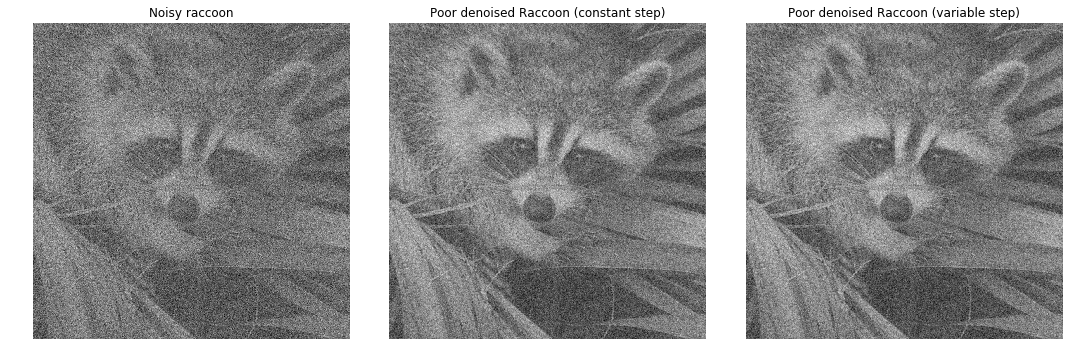

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(y, cmap='gray')
axes[0].set_title('Noisy raccoon')
axes[0].axis('off')

axes[1].imshow(re, cmap='gray')
axes[1].set_title('Poor denoised Raccoon (constant step)')
axes[1].axis('off')

axes[2].imshow(re1, cmap='gray')
axes[2].set_title('Poor denoised Raccoon (variable step)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


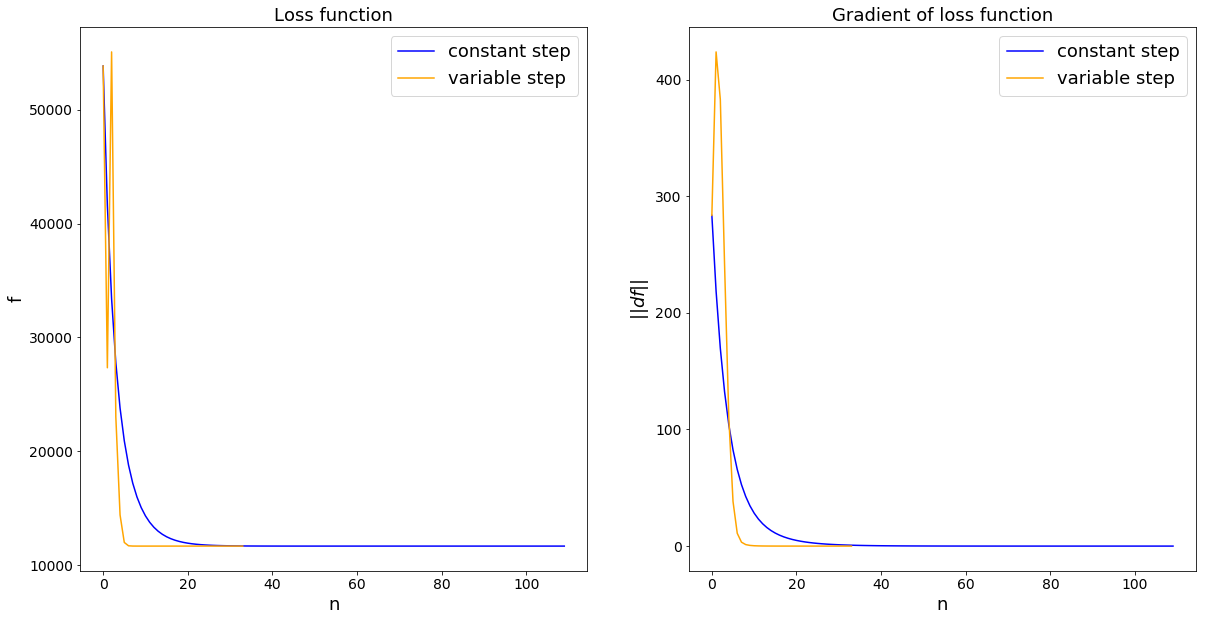

In [12]:
number = np.arange(len(fu))
number1 = np.arange(len(fu1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(number, fu, label="constant step", color="blue")
ax1.plot(number1, fu1, label="variable step", color="orange")
ax1.set_xlabel('n', fontsize=18)
ax1.set_ylabel('f', fontsize=18)
ax1.set_title ('Loss function', fontsize=18)
#plt.title('ROC curve')
ax1.legend(loc = "upper right", fontsize=18)

ax2.plot(number, dfu, label="constant step", color="blue")
ax2.plot(number1, dfu1, label="variable step", color="orange")
ax2.set_xlabel('n', fontsize=18)
ax2.set_ylabel('$||d f||$', fontsize=18)
#plt.title('ROC curve')
ax2.set_title ('Gradient of loss function', fontsize=18)
ax2.legend(loc = "upper right", fontsize=18)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
plt.show()

### Подход богатых студентов (Total Variation Denoising)
[Здесь](http://www.numerical-tours.com/matlab/optim_1_gradient_descent/) можно почитать мануал на [тему](https://en.wikipedia.org/wiki/Total_variation_denoising). Реализуйте функции $J(x)$ и $\nabla J(x)$ в этом подходе согласно мануалу.

In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
%reload_ext autoreload

Попробуйте 2 стратегии выбора шага:
* постоянную (придется подбирать шаг экспериментально)
* $\eta_k = \dfrac{\eta_0 }{\sqrt{k}}$, $\eta_0$ подбирать

Критерий остановки: $\|\nabla f(x)\| \leq \varepsilon = 10^{-4}$

Напишите функцию, реализующую процедуру градиентного спуска и рисующую два графика $f(x_k), \nabla f(x_k)$

In [15]:
from scipy.optimize import minimize 
from scipy.optimize import line_search
from scipy.optimize import minimize_scalar

Перепробовал различные стратегии для сходимости градиентного спуска:

* Постоянный шаг
* Переменный шаг
* Наискорейшиый спуск (подбор шага решением одномерной задачи минимизации различными готовыми солверами, а также line search with strong Wolfe conditions )

Не удалось добится сходимости градиентным спуском(слишком медленно сходися к локальному минимуму). Придется воспользоваться готовым солвером.

In [16]:

# Напишите функцию, которая принимает на вход черно-белое изображение nxn пикселей, а возвращает тензор размера nxnx2,
# содержащий частные производные в каждой точке, рассчитанный по методу конечных разностей.
def div(x):
    g = x.copy()
    g[0] -= np.roll(g[0], -1, axis=0)
    g[1] -= np.roll(g[1], -1, axis=1)

    return g[0] + g[1]

def grad(x):
    return np.array([x - np.roll(x, 1, axis=i) for i in range(2)])


def norm_eps(x, eps=1e-3):
    return np.sqrt(x[0]**2 + x[1]**2 + eps**2)

def J_tv(x):
    return np.sum(norm_eps(grad(x)))

# Напишите функцию, которая считает градиент функции J(x) (она возвращает массив nxn)
def dJ_tv(x):
    g = grad(x)
    return div(g/norm_eps(g))

def f_tv(x, y, lambd):
    return np.sum((y-x)**2)/2 + lambd*J_tv(x)

def df_tv(x, y, lambd):
    return (x-y) + lambd*dJ_tv(x)


In [17]:
def rich_student_denoise(y, f, df, lambd):
    def f_flat(x_flat, y, lambd):
        x = x_flat.reshape(y.shape)
        return f(x, y, lambd), df(x, y, lambd).flatten()
    
    
    def call_back_func(x):
        func.append(f(x.reshape(y.shape), y, lambd))
        dfunc.append(np.linalg.norm(df(x.reshape(y.shape), y, lambd)))
        sys.stderr.write('\rf: %d, df: %f' % (func[-1], dfunc[-1]))
        sys.stderr.flush()
        
    x_flat = y.flatten()

    func = []
    dfunc = []
    
    res = minimize(f_flat, x_flat, args=(y, lambd), method='CG', jac=True,
                   callback=call_back_func, options={'disp':True}, tol = 1e-4)
    x = res.x.reshape(y.shape)
    
    return x, func, dfunc

In [23]:
la = 0.25
re2, fu2, df2 = rich_student_denoise (y, f_tv, df_tv, la)

f: 27965, df: 0.00051318

Optimization terminated successfully.
         Current function value: 27965.597633
         Iterations: 442
         Function evaluations: 654
         Gradient evaluations: 654


#### Сравним методы бедных и богатых студентов

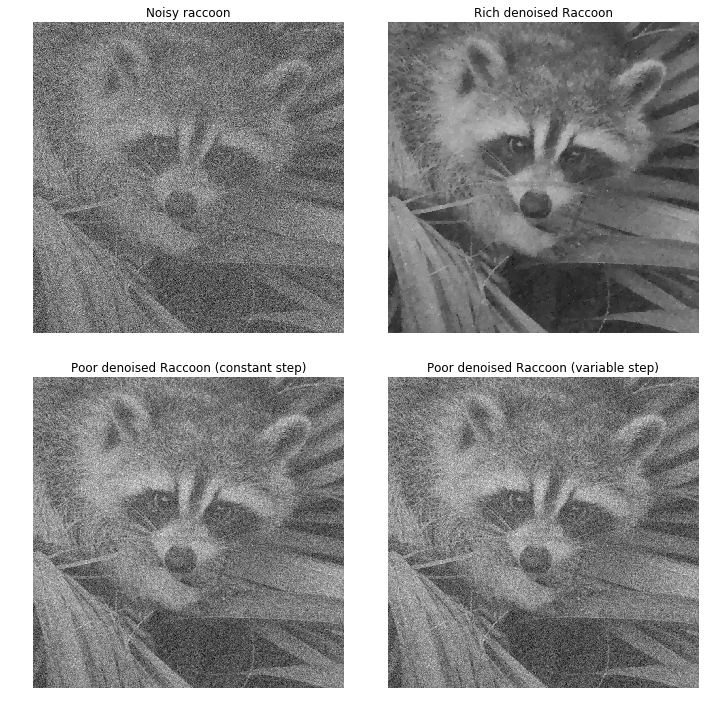

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(y, cmap='gray')
axes[0, 0].set_title('Noisy raccoon')
axes[0, 0].axis('off')

axes[0, 1].imshow(re2, cmap='gray')
axes[0, 1].set_title('Rich denoised Raccoon')
axes[0, 1].axis('off')

axes[1, 0].imshow(re, cmap='gray')
axes[1, 0].set_title('Poor denoised Raccoon (constant step)')
axes[1, 0].axis('off')

axes[1, 1].imshow(re1, cmap='gray')
axes[1, 1].set_title('Poor denoised Raccoon (variable step)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

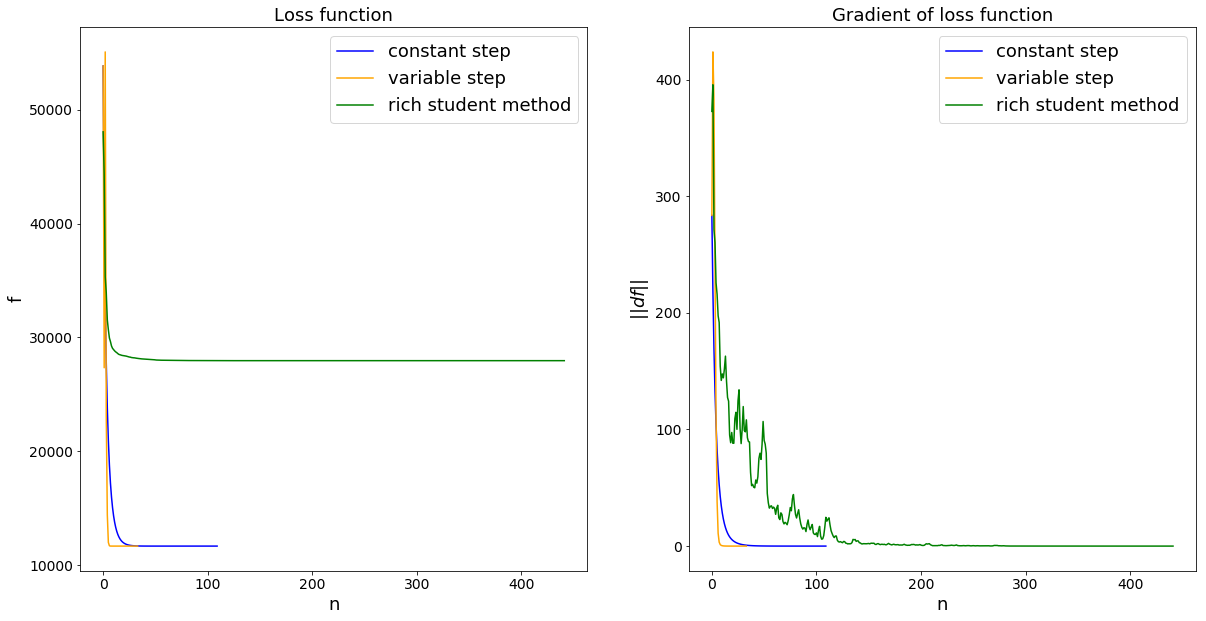

In [25]:
number = np.arange(len(fu))
number1 = np.arange(len(fu1))
number2 = np.arange(len(fu2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(number, fu, label="constant step", color="blue")
ax1.plot(number1, fu1, label="variable step", color="orange")
ax1.plot(number2, fu2, label="rich student method", color="green")

ax1.set_xlabel('n', fontsize=18)
ax1.set_ylabel('f', fontsize=18)
ax1.set_title ('Loss function', fontsize=18)
#plt.title('ROC curve')
ax1.legend(loc = "upper right", fontsize=18)

ax2.plot(number, dfu, label="constant step", color="blue")
ax2.plot(number1, dfu1, label="variable step", color="orange")
ax2.plot(number2, df2, label="rich student method", color="green")

ax2.set_xlabel('n', fontsize=18)
ax2.set_ylabel('$||d f||$', fontsize=18)
#plt.title('ROC curve')
ax2.set_title ('Gradient of loss function', fontsize=18)
ax2.legend(loc = "upper right", fontsize=18)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
plt.show()